In [23]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

from numba import njit, prange
from timeit import default_timer as timer

import scipy.io

In [3]:
dt = .001
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 5
bifurcate_time = 0
threshold = 70
R_initial = 32
eta = 0

In [4]:
speed_alpha = 33.842539
speed_beta = 1.821676
speed_sigma = 35.723187
speed_S = 2368.22093
speed_tauR = 0.33628
speed_tauG = 0.001002
speed_tauD = 0.226118
speed_params = [speed_alpha, speed_beta, speed_sigma, speed_S, speed_tauR, speed_tauG, speed_tauD]

In [5]:
accuracy_alpha = 34.695025
accuracy_beta = 0.978248
accuracy_sigma = 16.577909
accuracy_S = 350.064641
accuracy_tauR = 0.008438
accuracy_tauG = 0.112152
accuracy_tauD = 0.155874
accuracy_params = [accuracy_alpha, accuracy_beta, accuracy_sigma, accuracy_S, accuracy_tauR, accuracy_tauG, accuracy_tauD]

In [138]:
@njit(parallel=True, fastmath=True)
def ave_choice(coh, a, b, sgm, S, tauR, tauG, tauD):

    alpha = a

    nan_num = 0
    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in prange(10240):

        beta = 0
        V1, V2 = S, S

        R1_arr = np.zeros(int(dur / dt))
        R2_arr = np.zeros(int(dur / dt))
        # R1_arr[0] = ((alpha - 1) + np.sqrt((1 - alpha) ** 2 + 4 * S * (w11 + w12 - beta))) / (2 * (w11 + w12 - beta))
        # R2_arr[0] = ((alpha - 1) + np.sqrt((1 - alpha) ** 2 + 4 * S * (w22 + w21 - beta))) / (2 * (w22 + w21 - beta))
        R1_arr[0], R2_arr[0] = R_initial, R_initial

        G1_arr = np.zeros(int(dur / dt))
        G2_arr = np.zeros(int(dur / dt))
        G1_arr[0], G2_arr[0] = (w11 + w12 - beta) * R1_arr[0], (w22 + w21 - beta) * R2_arr[0]

        D1_arr = np.zeros(int(dur / dt))
        D2_arr = np.zeros(int(dur / dt))
        D1_arr[0], D2_arr[0] = beta * R1_arr[0], beta * R2_arr[0]

        noise_R1 = np.zeros(int(dur / dt))
        noise_R2 = np.zeros(int(dur / dt))
        noise_G1 = np.zeros(int(dur / dt))
        noise_G2 = np.zeros(int(dur / dt))
        noise_D1 = np.zeros(int(dur / dt))
        noise_D2 = np.zeros(int(dur / dt))

        for ti in range(1, int(dur / dt)):

            if ti >= bifurcate_time / dt:
                beta = b

            if ti >= bifurcate_time / dt and ti % 5 == 0:
                V1 = S * (1 + coh) + np.random.randn() * eta
                V2 = S * (1 - coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
            d_noiseR2 = (-noise_R2[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
            d_noiseG1 = (-noise_G1[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
            d_noiseG2 = (-noise_G2[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
            d_noiseD1 = (-noise_D1[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
            d_noiseD2 = (-noise_D2[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt

            d_R1 = (-R1_arr[ti - 1] + (alpha * R1_arr[ti - 1] + V1) / (1 + G1_arr[ti - 1])) * dt / tauR
            d_R2 = (-R2_arr[ti - 1] + (alpha * R2_arr[ti - 1] + V2) / (1 + G2_arr[ti - 1])) * dt / tauR
            d_G1 = (-G1_arr[ti - 1] + w11 * R1_arr[ti - 1] + w12 * R2_arr[ti - 1] - D1_arr[ti - 1]) * dt / tauG
            d_G2 = (-G2_arr[ti - 1] + w21 * R1_arr[ti - 1] + w22 * R2_arr[ti - 1] - D2_arr[ti - 1]) * dt / tauG
            d_D1 = (-D1_arr[ti - 1] + beta * R1_arr[ti - 1]) * dt / tauD
            d_D2 = (-D2_arr[ti - 1] + beta * R2_arr[ti - 1]) * dt / tauD

            noise_R1[ti] = noise_R1[ti - 1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti - 1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti - 1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti - 1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti - 1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti - 1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti - 1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti - 1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti - 1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti - 1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti - 1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti - 1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN
                nan_num += 1

    reaction_time += 120
    reaction_time *= dt

    return reaction_time, choice, nan_num

In [139]:
speed_RT, speed_choice = np.zeros(500), np.zeros(500)
accuracy_RT, accuracy_choice = np.zeros(500), np.zeros(500)

In [140]:
start = timer()
speed_nan, accuracy_nan = np.zeros(500), np.zeros(500)
for c in range(500):
    cur_speed_RT, cur_speed_choice, cur_speed_nan = ave_choice(c / 1000, *speed_params)
    cur_accuracy_RT, cur_accuracy_choice, cur_accuracy_nan = ave_choice(c / 1000, *accuracy_params)

    speed_RT[c], speed_choice[c] = np.nanmean(cur_speed_RT), np.nanmean(cur_speed_choice)
    accuracy_RT[c], accuracy_choice[c] = np.nanmean(cur_accuracy_RT), np.nanmean(cur_accuracy_choice)

    speed_nan[c] += cur_speed_nan
    accuracy_nan[c] += cur_accuracy_nan

    print("\r[EPOCH]: %d" % c, end='')
end = timer()-start

[EPOCH]: 499

In [141]:
def get_speed_empirical_mean_data():
    monkeyD = scipy.io.loadmat('behavData_dam.mat')

    speed = monkeyD['task'][0][0]
    speed_mat = speed[4][0][0]
    speed_coh = speed_mat[0]
    speed_ch = speed_mat[1]
    speed_rt = speed_mat[2]

    speed_coh_list = np.unique(speed_coh)
    speed_coh_list.sort()
    speed_rt_res, speed_choice_res = np.zeros(len(speed_coh_list)), np.zeros(len(speed_coh_list))

    for ind, coh in enumerate(speed_coh_list):
        speed_rt_res[ind] = (np.sum(speed_rt[np.where(speed_coh == coh)]) / len(speed_rt[np.where(speed_coh == coh)])) * dt
        speed_choice_res[ind] = np.sum(speed_ch[np.where(speed_coh == coh)]) / len(speed_ch[np.where(speed_coh == coh)])

    return speed_coh_list, speed_choice_res, speed_rt_res

In [142]:
def get_accuracy_empirical_mean_data():
    monkeyD = scipy.io.loadmat('behavData_dam.mat')

    accuracy = monkeyD['task'][0][1]
    accuracy_mat = accuracy[4][0][0]
    accuracy_coh = accuracy_mat[0]
    accuracy_ch = accuracy_mat[1]
    accuracy_rt = accuracy_mat[2]

    accuracy_coh_list = np.unique(accuracy_coh)
    accuracy_coh_list.sort()
    accuracy_rt_res, accuracy_choice_res = np.zeros(len(accuracy_coh_list)), np.zeros(len(accuracy_coh_list))

    for ind, coh in enumerate(accuracy_coh_list):
        accuracy_rt_res[ind] = (np.sum(accuracy_rt[np.where(accuracy_coh == coh)]) / len(accuracy_rt[np.where(accuracy_coh == coh)])) * dt
        accuracy_choice_res[ind] = np.sum(accuracy_ch[np.where(accuracy_coh == coh)]) / len(accuracy_ch[np.where(accuracy_coh == coh)])

    return accuracy_coh_list, accuracy_choice_res, accuracy_rt_res

In [143]:
D_speed_coh_list, D_speed_choice_res, D_speed_rt_res = get_speed_empirical_mean_data()
D_speed_coh_list *= 1000
D_speed_coh_list = D_speed_coh_list.astype(int)

D_accuracy_coh_list, D_accuracy_choice_res, D_accuracy_rt_res = get_accuracy_empirical_mean_data()
D_accuracy_coh_list *= 1000
D_accuracy_coh_list = D_accuracy_coh_list.astype(int)

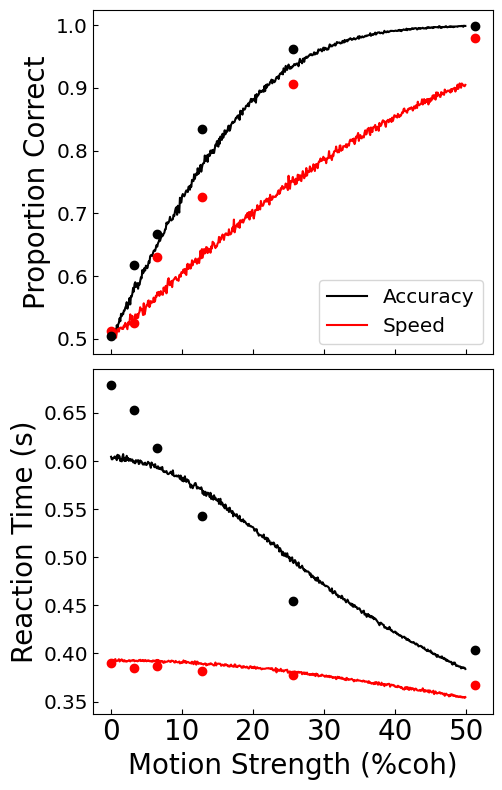

In [144]:
fig, (choice_ax, RT_ax) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

choice_ax.plot(accuracy_choice[:500], label="Accuracy", color='black')
choice_ax.plot(speed_choice[:500], label="Speed", color='red')
choice_ax.set_ylabel("Proportion Correct")

choice_ax.plot(D_speed_coh_list, D_speed_choice_res, 'ro')
choice_ax.plot(D_accuracy_coh_list, D_accuracy_choice_res, 'ko')

RT_ax.plot(accuracy_RT[:500], label="Accuracy", color='black')
RT_ax.plot(speed_RT[:500], label="Speed", color='red')
RT_ax.set_ylabel("Reaction Time (s)")

RT_ax.plot(D_speed_coh_list, D_speed_rt_res, 'ro')
RT_ax.plot(D_speed_coh_list, D_accuracy_rt_res, 'ko')

RT_ax.set_xlabel("Motion Strength (%coh)")
RT_ax.xaxis.set_ticks(np.arange(0, 600, 100))
RT_ax.xaxis.set_ticklabels(np.arange(0, 60, 10))

RT_ax.grid(False)
RT_ax.tick_params(axis='x', direction="in")
RT_ax.tick_params(axis="y", direction="in")
RT_ax.tick_params(bottom=True, left=True)
RT_ax.spines['bottom'].set_color('0')
RT_ax.spines['left'].set_color('0')
RT_ax.patch.set_facecolor('white')

choice_ax.grid(False)
choice_ax.tick_params(axis='x', direction="in")
choice_ax.tick_params(axis="y", direction="in")
choice_ax.tick_params(bottom=True, left=True)
choice_ax.spines['bottom'].set_color('0')
choice_ax.spines['left'].set_color('0')
choice_ax.patch.set_facecolor('white')
choice_ax.legend()

params = {
    'legend.fontsize': 'x-large',
     'axes.labelsize': 20,
     'axes.titlesize': 20,
     'xtick.labelsize': 20,
     'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)

plt.tight_layout()
plt.savefig("../Hanks/Rstlt/monkeyD_speed_v1/RT & ACC.tiff", format="tiff")